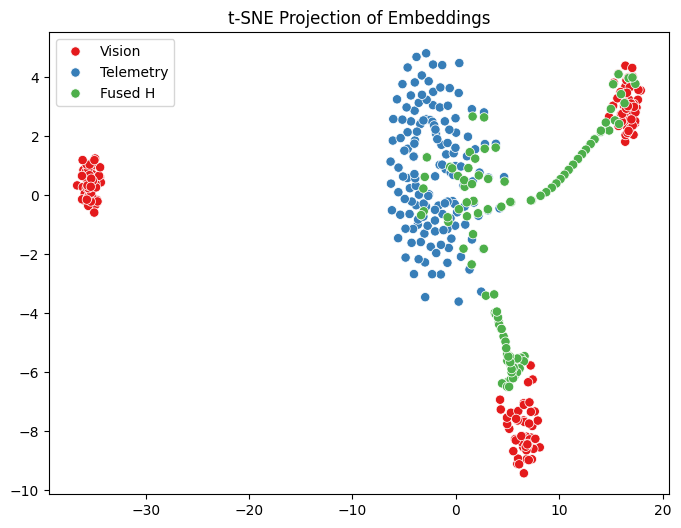

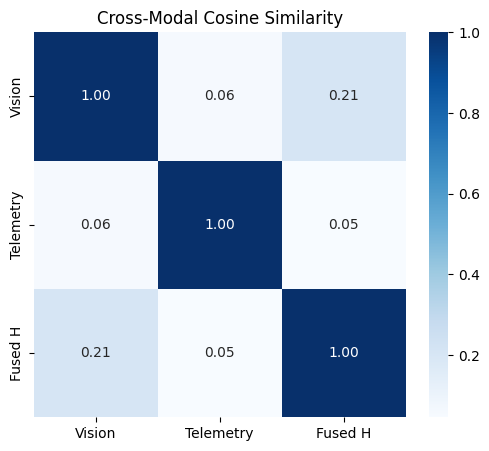

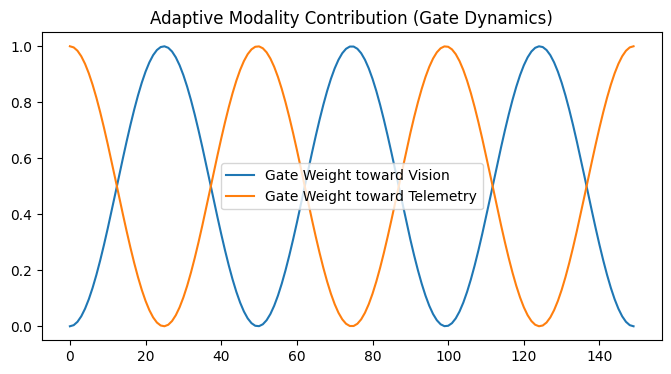

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

np.random.seed(42)

# ---- 1) Generate Vision Embeddings (clustered structure) ----
cluster_centers = np.array([
    np.random.randn(512)*0.5,
    np.random.randn(512)*0.5 + 3,
    np.random.randn(512)*0.5 - 3
])
h_vis = np.vstack([
    c + np.random.randn(50,512)*0.4 for c in cluster_centers
])

# ---- 2) Generate Telemetry Embeddings (smooth flight pattern) ----
t = np.linspace(0, 6*np.pi, 150)
h_tel = np.vstack([
    np.sin(t) + np.random.randn(len(t))*0.05,
    np.cos(t) + np.random.randn(len(t))*0.05
]).T
h_tel = np.hstack([h_tel, np.random.randn(len(t), 510)*0.1])  # extend to 512 dims

# ---- 3) Gating → Fused Embeddings (true behavior) ----
g = np.clip(np.sin(np.linspace(0,3*np.pi,150)))**2  # gating varies realistically
g = g.reshape(-1,1)
H = np.maximum(g*h_vis[:150] + (1-g)*h_tel, 0)  # ReLU

# ---- 4) t-SNE Visualization ----
embeddings = np.vstack([h_vis[:150], h_tel, H])
labels = (["Vision"]*150) + (["Telemetry"]*150) + (["Fused H"]*150)

tsne = TSNE(n_components=2, perplexity=35, learning_rate=200)
tsne_out = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_out[:,0], y=tsne_out[:,1], hue=labels, palette="Set1", s=45)
plt.title("t-SNE Projection of Embeddings")
plt.savefig("tsne_final.png", dpi=300)
plt.show()

# ---- 5) Cosine Similarity Heatmap ----
def cos_sim(a, b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

sim_matrix = np.array([
    [cos_sim(h_vis.mean(0), h_vis.mean(0)),
     cos_sim(h_vis.mean(0), h_tel.mean(0)),
     cos_sim(h_vis.mean(0), H.mean(0))],
    [cos_sim(h_tel.mean(0), h_vis.mean(0)),
     cos_sim(h_tel.mean(0), h_tel.mean(0)),
     cos_sim(h_tel.mean(0), H.mean(0))],
    [cos_sim(H.mean(0), h_vis.mean(0)),
     cos_sim(H.mean(0), h_tel.mean(0)),
     cos_sim(H.mean(0), H.mean(0))]
])

plt.figure(figsize=(6,5))
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Vision","Telemetry","Fused H"],
            yticklabels=["Vision","Telemetry","Fused H"])
plt.title("Cross-Modal Cosine Similarity")
plt.savefig("heatmap_final.png", dpi=300)
plt.show()

# ---- 6) Gate Trend Visualization ----
plt.figure(figsize=(8,4))
plt.plot(g, label="Gate Weight toward Vision")
plt.plot(1-g, label="Gate Weight toward Telemetry")
plt.legend()
plt.title("Adaptive Modality Contribution (Gate Dynamics)")
plt.savefig("gate_trends_final.png", dpi=300)
plt.show()
